# Problem 1

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# This new configuration allows for the use of GPU acceleration on Apple Silicon Macs
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
print(device)
torch.manual_seed(189898) # Last 6 digits of my A# without the leading zeros

cuda


In [8]:
# Check your Current Working Directory
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
#Set Batch Size
batch_size = 32

# Download the MNIST dataset to local drive. A new folder "data" will be created in teh current directory to store data
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Use a data loader to shuffle and batch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Hyperparameters
# Network Architecture
input_size = 784
num_classes = 10

# Training Parameters
num_epochs = 6

# Fully connected neural network with two hidden layers
class NeuralNet(nn.Module):
    def __init__(self, in_size, h1, h2, n_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(h2, n_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
# Define the Loss Function and Optimizer
criterion = torch.nn.CrossEntropyLoss()

In [11]:
# Train the model
learning_rates = [0.05, 0.1]
hidden_sizes = [[1568, 1568], [3136, 1568], [1568, 784]] # These values should all produce 97+% accuracy
best_performer = 0
best_parameters = []

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        total_step = len(train_loader)
        # Define the model object and the optimizer
        model = NeuralNet(input_size, hidden_size[0], hidden_size[1], num_classes).to(device)
        optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                # Move tensors to the configured device
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model.forward(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress every 100 steps
                if (i+1) % 100 == 0:
                    print(f'Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {round(float(loss.item()), 4)}')

    # Test the model once you finish training
        with torch.no_grad(): # In test phase we don't need to compute gradients (for memory efficiency)
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)

                # get network outputs
                outputs = model.forward(images)
                throwaway, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            if correct > best_performer:
                # Save the best performing model for future use
                best_performer = correct
                torch.save(model.state_dict(), 'model.ckpt')
                best_parameters = [hidden_size, learning_rate]
            print(f"Accuracy of the network for the 10,000 test images: {(100 * correct / total)}%, with learning rate: {learning_rate}, and {hidden_size} hidden neurons")
            print("\n\n")

print(f"Best Parameters: hidden_size={best_parameters[0]}, lr={best_parameters[1]}")
print(f"Best Accuracy: {100 * best_performer / total}")

Epoch[1/6], Step [100/1875], Loss: 0.7621
Epoch[1/6], Step [200/1875], Loss: 0.3125
Epoch[1/6], Step [300/1875], Loss: 0.4455
Epoch[1/6], Step [400/1875], Loss: 0.3216
Epoch[1/6], Step [500/1875], Loss: 0.5485
Epoch[1/6], Step [600/1875], Loss: 0.2954
Epoch[1/6], Step [700/1875], Loss: 0.1801
Epoch[1/6], Step [800/1875], Loss: 0.4372
Epoch[1/6], Step [900/1875], Loss: 0.1876
Epoch[1/6], Step [1000/1875], Loss: 0.1108
Epoch[1/6], Step [1100/1875], Loss: 0.2353
Epoch[1/6], Step [1200/1875], Loss: 0.2113
Epoch[1/6], Step [1300/1875], Loss: 0.4513
Epoch[1/6], Step [1400/1875], Loss: 0.3942
Epoch[1/6], Step [1500/1875], Loss: 0.2696
Epoch[1/6], Step [1600/1875], Loss: 0.0851
Epoch[1/6], Step [1700/1875], Loss: 0.2241
Epoch[1/6], Step [1800/1875], Loss: 0.2006
Epoch[2/6], Step [100/1875], Loss: 0.1291
Epoch[2/6], Step [200/1875], Loss: 0.1492
Epoch[2/6], Step [300/1875], Loss: 0.1766
Epoch[2/6], Step [400/1875], Loss: 0.2276
Epoch[2/6], Step [500/1875], Loss: 0.1348
Epoch[2/6], Step [600/187

In [12]:
# originally tested a range from 0.001 to 10 with order of magnitude increases for lr, 1578*1578, 784*1568, and 1568*784 hidden layer sizes with batch size of 20 and trained for 10 epochs
# For lr >= 1, loss=nan, result=random guessing
# 98.16%, 0.1, [1568,784]
# 96.57%, 0.01, [1568,784]
# 91.27%, 0.001, [1568,784]
# 97.62%, 0.1, [784, 1568]
# 96.53%, 0.01, [784, 1568]
# 91.20%, 0.001, [784, 1568]
# 98.09%, 0.1, [1568, 1568]
# 96.89%, 0.01, [1568, 1568]
# 91.24%, 0.001, [1568, 1568]

# Problem 4

In [1]:
# Import packages
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset and split into training and testing sets
mnist = loadmat('mnist_49_3000.mat')
X = mnist['x']
y = mnist['y'][0]
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=1000, random_state=42)

In [3]:
# Convert labels
def converter(inp):
    if inp > 0:
        return 1
    else:
        return 0

y_train_mod = [converter(val) for val in y_train]
y_test_mod  = [converter(val) for val in y_test]

In [5]:
# Define the model and regression structures
class LogisticRegression(nn.Module):
    def __init__(self, x_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(x_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

class LogisticRegressionGradientDescent:
    def __init__(self, lr=0.01, lamb=10, num_iter=1000, x_dim=785, fit_intercept=True):
        self.lr = lr
        self.lamb = lamb
        self.num_iter = num_iter
        self.x_dim = x_dim
        self.fit_intercept = fit_intercept
        self.model = LogisticRegression(x_dim)
        
    def __add_intercept(self, x):
        intercept = np.ones((x.shape[0], 1))
        return np.concatenate((intercept, x), axis=1)
    
    def fit(self, x, y):
        if self.fit_intercept:
            x = self.__add_intercept(x)
        
        x = torch.tensor(x).float()
        y = torch.tensor(y).float()
        
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        
        print("Training Error:")
        for epoch in range(self.num_iter):
            # Predict and get weights
            optimizer.zero_grad()
            y_pred = self.model.forward(x)
            theta = self.model.linear.weight
            
            # Calculate loss using the function from the 4.1 in homework document
            regularization_offset = self.lamb * (torch.dot(theta[:, 0], theta[:, 0]))
            loss = criterion(y_pred, y[:, None]) + regularization_offset
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{num_iter}: {float(loss)}")
        
        print(f"Train Error: {float(loss)}")
    
    def predict_confidence(self, x):
        if self.fit_intercept:
            x = self.__add_intercept(x)
        x = torch.tensor(x).float()
        return self.model.forward(x)

    def predict(self, x, threshold):
        preds = self.predict_confidence(x)
        return preds >= threshold

In [6]:
# Gradient descent parameters
learning_rates = [0.1, 0.5, 1]
lambs = [0.01, 0.1, 0.5, 0.9, 1]
thresholds = [0.5]
num_iter = 1000

max_correct = 0
best_params = []

# Initialize the model, loss function, and optimizer
for lamb in lambs:
    print(f"Lambda: {lamb}")
    for learning_rate in learning_rates:
        print(f"Learning Rate: {learning_rate}")
        model = LogisticRegressionGradientDescent(lr=learning_rate, lamb=lamb, num_iter=num_iter, x_dim=(X_train.shape[1] + 1))
        model.fit(X_train, y_train_mod)
        
        print("Thresholds:")
        for threshold in thresholds:
            preds = model.predict(X_test, threshold)
            predictions = []
            for pred in preds:
                if pred:
                    predictions.append(1)
                else:
                    predictions.append(0)
            
            correct = 0
            total = 0
            for i, val in enumerate(predictions):
                total += 1
                if val == y_test_mod[i]:
                    correct += 1
            if correct > max_correct:
                max_correct = correct
                best_params = [learning_rate, lamb, threshold]
                torch.save(model.model.state_dict(), 'log_reg.ckpt')
            print(f"{threshold}: Correctly predicted: {correct}/{total}")
        print("")
    print("")
print(f"Best Parameters: lr={best_params[0]}, lambda={best_params[1]}, threshold={best_params[2]}")
print(f"Best Performance: {max_correct}/{total}")

Lambda: 0.01
Learning Rate: 0.1
Training Error:
Epoch 0/1000: 0.695872962474823
Epoch 100/1000: 0.1909906566143036
Epoch 200/1000: 0.1478344351053238
Epoch 300/1000: 0.12891407310962677
Epoch 400/1000: 0.11761438846588135
Epoch 500/1000: 0.10984516143798828
Epoch 600/1000: 0.10404790192842484
Epoch 700/1000: 0.099482960999012
Epoch 800/1000: 0.09574859589338303
Epoch 900/1000: 0.09260567277669907
Train Error: 0.08992718905210495
Thresholds:
0.5: Correctly predicted: 970/1000

Learning Rate: 0.5
Training Error:
Epoch 0/1000: 0.6813779473304749
Epoch 100/1000: 0.10566457360982895
Epoch 200/1000: 0.08854673057794571
Epoch 300/1000: 0.07960560917854309
Epoch 400/1000: 0.0736313983798027
Epoch 500/1000: 0.06916894763708115
Epoch 600/1000: 0.06561824679374695
Epoch 700/1000: 0.06267504394054413
Epoch 800/1000: 0.06016416475176811
Epoch 900/1000: 0.05797581747174263
Train Error: 0.056055232882499695
Thresholds:
0.5: Correctly predicted: 971/1000

Learning Rate: 1
Training Error:
Epoch 0/1000:

In [7]:
# Train the model again using the best parameters found in the grid sweep above
model = LogisticRegressionGradientDescent(lr=best_params[0], lamb=best_params[1], num_iter=num_iter, x_dim=X_train.shape[1] + 1)
model.model.load_state_dict(torch.load("log_reg.ckpt"))
#%time model.fit(X_train, y_train_mod)

# Generate predictions for the test set
preds = model.predict(X_test, best_params[2])
predictions = []
for pred in preds:
    if pred:
        predictions.append(1)
    else:
        predictions.append(0)

correct = 0
total = 0
incorrect_indices = []
for i, val in enumerate(predictions):
    total += 1
    if val == y_test_mod[i]:
        correct += 1
    else:
        incorrect_indices.append(i)

print(f"Accuracy: {correct}/{total}")

Accuracy: 974/1000


In [8]:
# Separate the incorrectly classified images
incorrect = []
labels = []
for i, pixels in enumerate(X_test):
    if i in incorrect_indices:
        incorrect.append(pixels)
        labels.append(y_test_mod[i])

incorrect_array = np.array(incorrect)
confidences = model.predict_confidence(incorrect_array)

for i in range(len(labels)):
    if labels[i] == 1:
        labels[i] = 4
    else:
        labels[i] = 9

abs_conf = []
for conf in confidences:
    av = abs(float(conf) - 0.5) + 0.5
    abs_conf.append(av)

df = pd.DataFrame({'x': incorrect, 'y': labels, 'confidence': abs_conf})
df_sorted = df.sort_values(by=["confidence"], ascending=False)
df_sorted.reset_index(inplace=True)

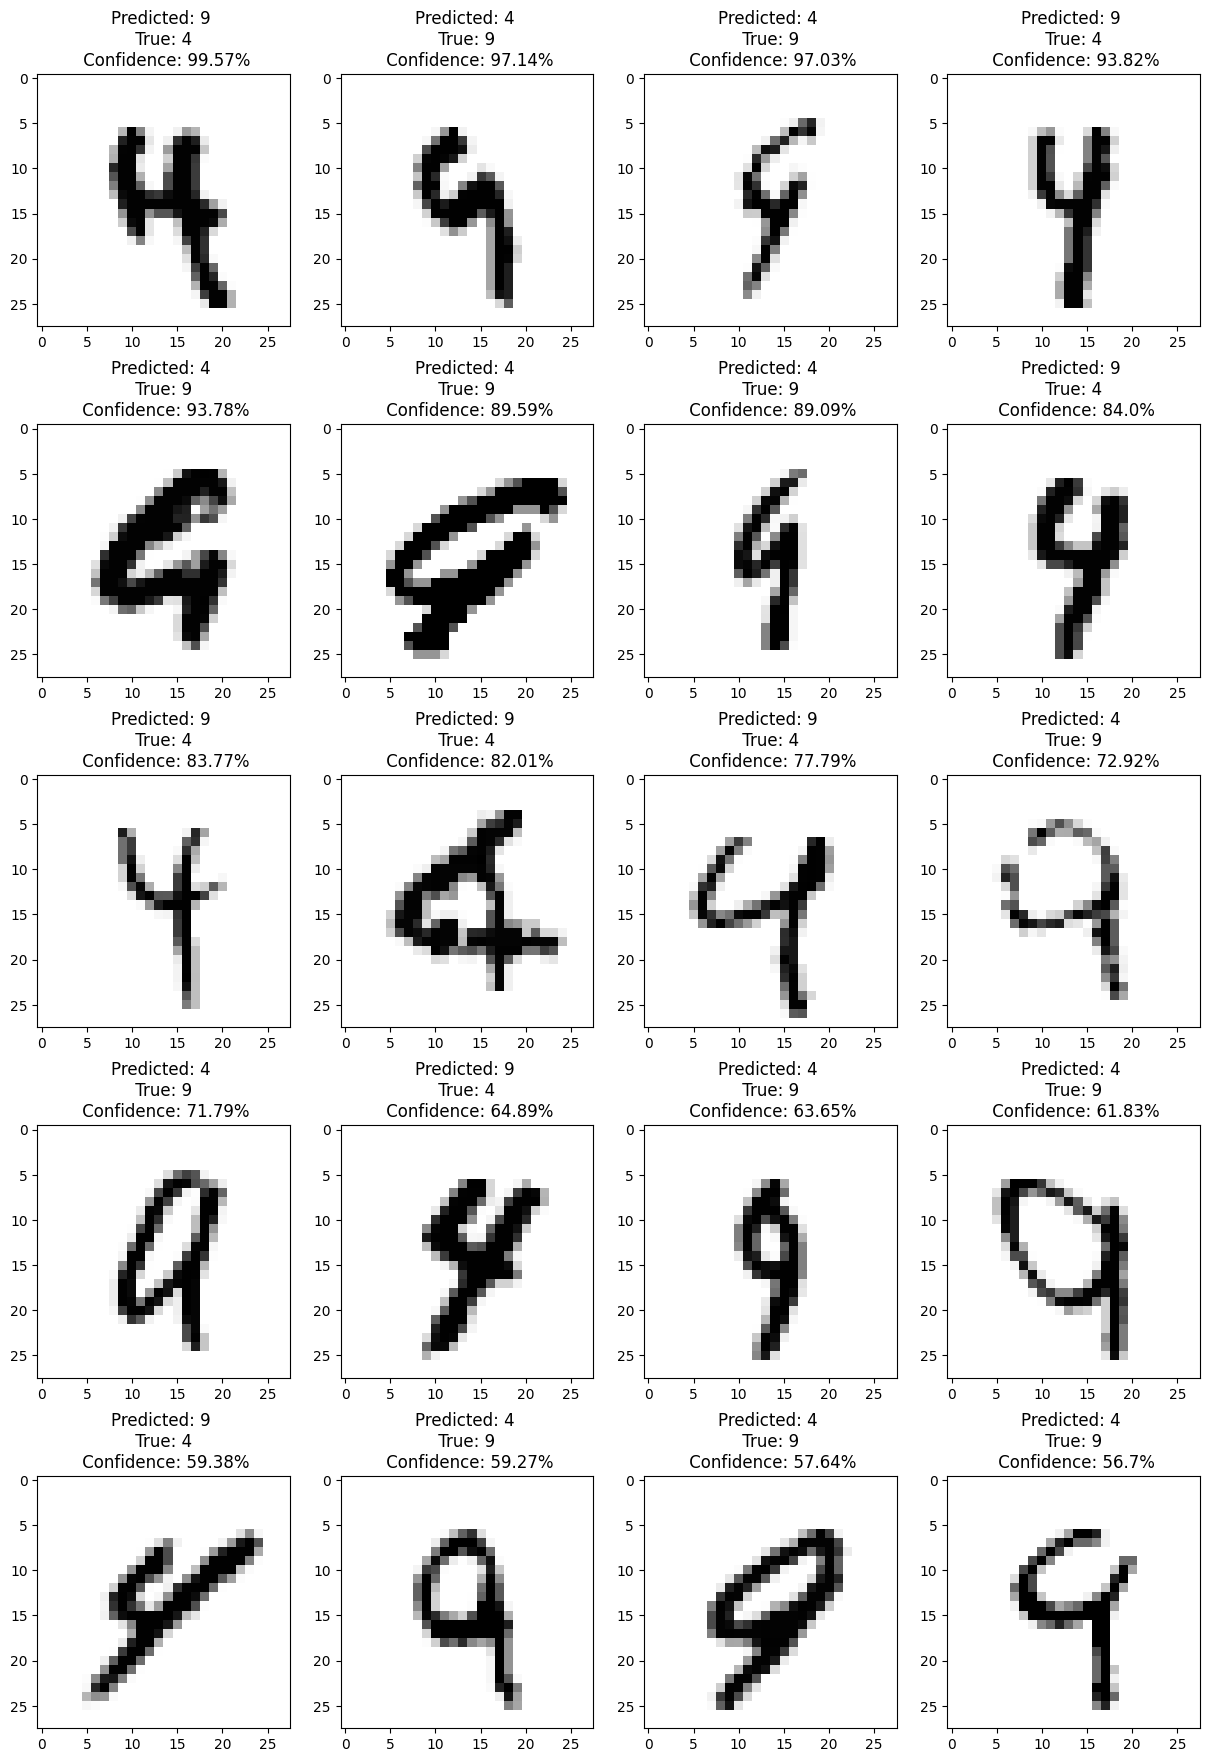

In [9]:
# Display the most confidently predicted incorrect images
plt.figure(figsize=(15, 22))
for index, row in df_sorted.truncate(after=19).iterrows():
    image = row['x'].reshape(28, 28)
    if row['y'] == 4:
        true = 9
    else:
        true = 4
    plt.subplot(5, 4, index + 1)
    plt.imshow(image, cmap='Greys')
    plt.title(f"Predicted: {row['y']} \n True: {true} \n Confidence: {round(row['confidence'] * 100, 2)}%")